# Thư viện và các hàm/biến không đổi

In [19]:

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score
import segmentation_models_pytorch as smp
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import tifffile as tiff
from PIL import Image
import glob
import numpy as np
import os

# Check if GPU is available
import torch
print(torch.cuda.is_available())       # Should be True
print(torch.version.cuda)              # Should show a version (e.g., '11.8')
print(torch.cuda.get_device_name(0))   # Should show 'NVIDIA GeForce GTX 1060'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_paths = sorted(glob.glob('IMG/dataset512px/images/*.tif'))
mask_paths = sorted(glob.glob('IMG/dataset512px/masks/*.tif'))

True
12.8
NVIDIA GeForce GTX 1060 6GB


In [2]:
# class RoofDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, transform=None): # Initialize the dataset
#         self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
#         self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tif')])
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img = tiff.imread(self.image_paths[idx])
#         mask = tiff.imread(self.mask_paths[idx])

#         if len(img.shape) == 2:  # Grayscale to RGB
#             img = np.stack([img]*3, axis=-1)

#         if mask.max() > 1:
#             mask = mask // 255

#         if self.transform:
#             augmented = self.transform(image=img, mask=mask)
#             img = augmented["image"]
#             mask = augmented["mask"]

#         return img, mask.long()

class RoofDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = tiff.imread(self.image_paths[idx])
        mask = tiff.imread(self.mask_paths[idx])

        if len(img.shape) == 2:
            img = np.stack([img] * 3, axis=-1)

        if mask.max() > 1:
            mask = mask // 255

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        return img, mask.long()


## Test train

In [4]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

# Create dataset and loader

train_dataset = RoofDataset('IMG/dataset512px/images', 'IMG/dataset512px/masks', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)


In [7]:
# Model
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = smp.losses.DiceLoss(mode='binary')

# Count image and mask pairs
print(f"Number of image-mask pairs: {len(train_dataset)}")


Number of image-mask pairs: 18000


In [8]:
# Training loop
for epoch in range(5):  # Increase for real training
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()  # Add channel dimension

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.3038
Epoch 2, Loss: 0.1816
Epoch 3, Loss: 0.1572
Epoch 4, Loss: 0.1455
Epoch 5, Loss: 0.1397


# Dùng Sklearn để train model có validation

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

# Split image-mask paths
train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Update datasets
train_dataset = RoofDataset(train_imgs, train_masks, transform=transform)
val_dataset = RoofDataset(val_imgs, val_masks, transform=transform)

In [8]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

In [9]:
# Model
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = smp.losses.DiceLoss(mode='binary')

In [ ]:
# Training loop with validation
best_val_loss = float('inf')

for epoch in range(20):  # Increase for real training
    model.train()
    total_train_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device).unsqueeze(1).float()
            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_masks)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'roof_segmentation_epoch.pth')

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

print("Training complete. Best model saved as 'best_model.pth'.")

Epoch 1: Train Loss = 0.3089, Val Loss = 0.2077
Epoch 2: Train Loss = 0.1839, Val Loss = 0.1749
Epoch 3: Train Loss = 0.1627, Val Loss = 0.1640
Epoch 4: Train Loss = 0.1535, Val Loss = 0.1557
Epoch 5: Train Loss = 0.1458, Val Loss = 0.1555
Epoch 6: Train Loss = 0.1393, Val Loss = 0.1506
Epoch 7: Train Loss = 0.1381, Val Loss = 0.1455
Epoch 8: Train Loss = 0.1333, Val Loss = 0.1428
Epoch 9: Train Loss = 0.1266, Val Loss = 0.1413
Epoch 10: Train Loss = 0.1272, Val Loss = 0.1412
Epoch 11: Train Loss = 0.1238, Val Loss = 0.1411
Epoch 12: Train Loss = 0.1208, Val Loss = 0.1420
Epoch 13: Train Loss = 0.1167, Val Loss = 0.1392
Epoch 14: Train Loss = 0.1141, Val Loss = 0.1361
Epoch 15: Train Loss = 0.1159, Val Loss = 0.1386
Epoch 16: Train Loss = 0.1139, Val Loss = 0.1344
Epoch 17: Train Loss = 0.1080, Val Loss = 0.1331
Epoch 18: Train Loss = 0.1082, Val Loss = 0.1350
Epoch 19: Train Loss = 0.1039, Val Loss = 0.1344
Epoch 20: Train Loss = 0.1056, Val Loss = 0.1362
Training complete. Best model

# Thử nghiệm các architectures

In [10]:
# Config
architectures = ["Unet", "UnetPlusPlus", "FPN", "DeepLabV3Plus", "LinkNet", "PSPNet"]
encoder_name = "resnet34"  # You can test others later like "efficientnet-b0"
num_epochs = 5
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
save_dir = "trained_models"
os.makedirs(save_dir, exist_ok=True)

# Loss
loss_fn = smp.losses.DiceLoss(mode='binary')

# Loop through architectures
for arch in architectures:
    print(f"\nTraining {arch}...\n")

    model = smp.create_model(arch, encoder_name=encoder_name, in_channels=3, classes=1, activation=None)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_images, val_masks in val_loader:
                val_images = val_images.to(device)
                val_masks = val_masks.to(device).unsqueeze(1).float()
                val_outputs = model(val_images)
                val_loss = loss_fn(val_outputs, val_masks)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"{arch} | Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_path = os.path.join(save_dir, f"{arch}_best_5_epochs.pth")
            torch.save(model.state_dict(), model_path)

    print(f"Finished training {arch}. Best Val Loss: {best_val_loss:.4f}")



Training Unet...

Unet | Epoch 1/5 - Train Loss: 0.2892, Val Loss: 0.2123
Unet | Epoch 2/5 - Train Loss: 0.2025, Val Loss: 0.1917
Unet | Epoch 3/5 - Train Loss: 0.1928, Val Loss: 0.1902
Unet | Epoch 4/5 - Train Loss: 0.1818, Val Loss: 0.1730
Unet | Epoch 5/5 - Train Loss: 0.1742, Val Loss: 0.1718
Finished training Unet. Best Val Loss: 0.1718

Training UnetPlusPlus...

UnetPlusPlus | Epoch 1/5 - Train Loss: 0.2634, Val Loss: 0.1903
UnetPlusPlus | Epoch 2/5 - Train Loss: 0.1941, Val Loss: 0.1760
UnetPlusPlus | Epoch 3/5 - Train Loss: 0.1806, Val Loss: 0.1829
UnetPlusPlus | Epoch 4/5 - Train Loss: 0.1713, Val Loss: 0.1685
UnetPlusPlus | Epoch 5/5 - Train Loss: 0.1682, Val Loss: 0.1659
Finished training UnetPlusPlus. Best Val Loss: 0.1659

Training FPN...

FPN | Epoch 1/5 - Train Loss: 0.2775, Val Loss: 0.2089
FPN | Epoch 2/5 - Train Loss: 0.2167, Val Loss: 0.1942
FPN | Epoch 3/5 - Train Loss: 0.1988, Val Loss: 0.1973
FPN | Epoch 4/5 - Train Loss: 0.1957, Val Loss: 0.1943
FPN | Epoch 5/5 

# Hàm xử lí và kiểm tra sau train (luôn chạy đầu trước khi test model)

In [ ]:
# Save the model
# torch.save(model.state_dict(), "roof_segmentation_5Epoch_32patchsize_67mins.pth")

In [ ]:
def load_model(model_arch, path, encoder="resnet34"):
    model = smp.create_model(model_arch, encoder_name=encoder, classes=1, activation=None)
    model.load_state_dict(torch.load(path, map_location=device), strict=False)
    model.to(device)
    model.eval()
    return model

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512))
    image = np.array(image) / 255.0

    # Apply ImageNet normalization (mean/std from torchvision.models)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std

    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    return image


def predict(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)  # only once
        print("Output stats:", output.min().item(), output.max().item())
        mask = output.squeeze().cpu().numpy()
    return (mask > 0.5).astype(np.uint8)

def evaluate_model(model, image_tensor, true_mask):
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = (output > 0.5).astype(np.uint8)

    true_mask = true_mask.squeeze().cpu().numpy()
    true_mask = (true_mask > 0).astype(np.uint8)

    flat_pred = pred_mask.flatten()
    flat_true = true_mask.flatten()

    iou = jaccard_score(flat_true, flat_pred, average='binary')
    precision = precision_score(flat_true, flat_pred, average='binary')
    recall = recall_score(flat_true, flat_pred, average='binary')
    f1 = f1_score(flat_true, flat_pred, average='binary')

    return iou, precision, recall, f1, pred_mask


## Xử lí lô thử nghiệm các architectures

In [60]:
model0 = load_model("Unet", "trained_models/Unet_best_5_epochs.pth")
model1 = load_model("FPN", "trained_models/FPN_best_5_epochs.pth")
model2 = load_model("UnetPlusPlus", "trained_models/UnetPlusPlus_best_5_epochs.pth")
model3 = load_model("DeepLabV3Plus", "trained_models/DeepLabV3Plus_best_5_epochs.pth")
model4 = load_model("LinkNet", "trained_models/LinkNet_best_5_epochs.pth")
model5 = load_model("PSPNet", "trained_models/PSPNet_best_5_epochs.pth")

Output stats: 2.4648667235429612e-15 1.0
Output stats: 8.340288844652068e-22 1.0
Output stats: 1.5581430592660043e-19 1.0
Output stats: 1.0897050279064604e-15 1.0
Output stats: 4.115472620469518e-07 1.0
Output stats: 0.0 1.0
Unique values in true: [0 1]
Unique values in pred: [0 1]
Unique values in true: [0 1]
Unique values in pred: [0 1]
Unique values in true: [0 1]
Unique values in pred: [0 1]
Unique values in true: [0 1]
Unique values in pred: [0 1]
Unique values in true: [0 1]
Unique values in pred: [0 1]
Unique values in true: [0 1]
Unique values in pred: [0 1]


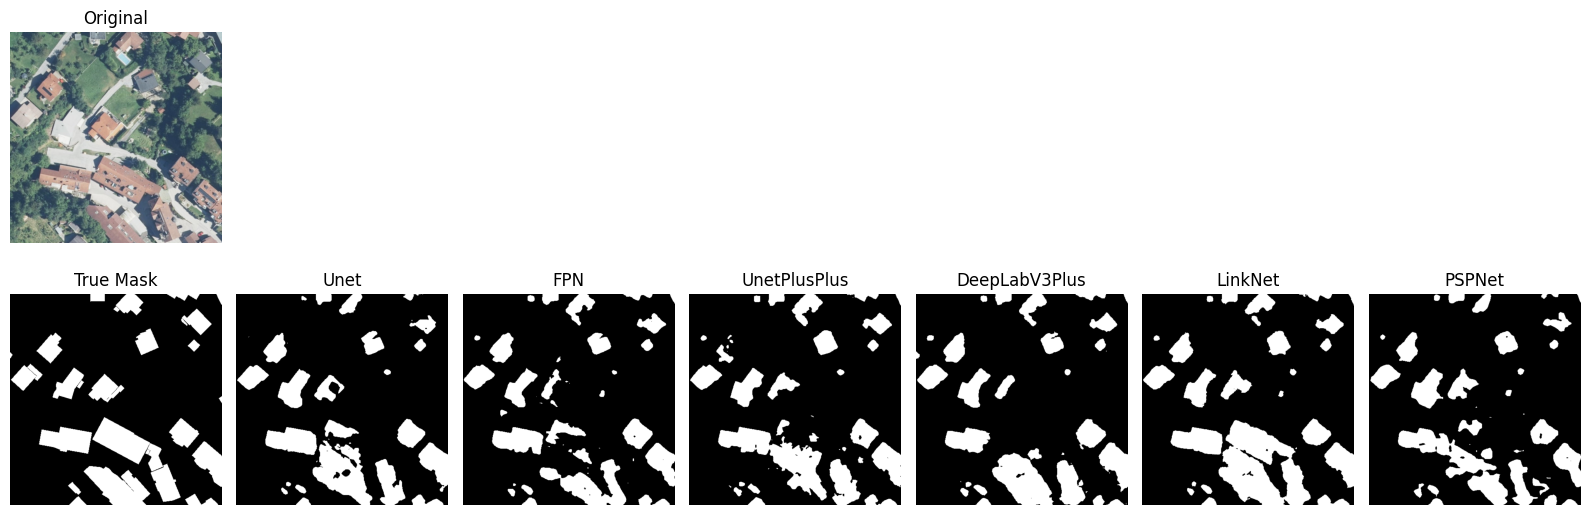


			Evaluation Results:
Model       	 IOU          	Precision    	Recall       	F1          
Unet        	 0.6586       	0.8282       	0.7627       	0.7941      
FPN         	 0.6380       	0.8497       	0.7192       	0.7790      
UnetPlusPlus	 0.5905       	0.7801       	0.7085       	0.7426      
DeepLabV3Plus	 0.6278       	0.8164       	0.7310       	0.7714      
LinkNet     	 0.7523       	0.8226       	0.8981       	0.8587      
PSPNet      	 0.5626       	0.7816       	0.6675       	0.7201      


In [74]:
image_path = "tyrol-w1_patch_046.tif"
true_mask_path = "tyrol-w1_patch_046_mask.tif"
input_img = np.array(Image.open(image_path).resize((512, 512)))

image_tensor = preprocess_image(image_path)

masks = [
    predict(model0, image_tensor),
    predict(model1, image_tensor),
    predict(model2, image_tensor),
    predict(model3, image_tensor),
    predict(model4, image_tensor),
    predict(model5, image_tensor),
]

titles = ["Unet", "FPN", "UnetPlusPlus", "DeepLabV3Plus", "LinkNet", "PSPNet"]

if true_mask_path != "":
    true_mask = Image.open(true_mask_path).resize((512, 512))
    true_mask = torch.tensor(np.array(true_mask)).unsqueeze(0).unsqueeze(0).to(device)
    results = []
    for i, model in enumerate([model0, model1, model2, model3, model4, model5]):
        iou, precision, recall, f1, pred_mask = evaluate_model(model, image_tensor, true_mask)
        results.append((iou, precision, recall, f1))

plt.figure(figsize=(16, 8))
plt.subplot(1, 7, 1)
plt.imshow(true_mask.squeeze().cpu().numpy(), cmap='gray')
plt.title("True Mask")
plt.axis("off")
plt.subplot(3, 7, 1)
plt.imshow(input_img)
plt.title("Original")
plt.axis("off")

for i, mask in enumerate(masks):
    plt.subplot(1, 7, i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# Print evaluation results
if true_mask_path != "":
    print("\n\t\t\t\033[1mEvaluation Results:\033[0m")
    print(f"{'Model':<12}\t {'IOU':<12} \t{'Precision':<12} \t{'Recall':<12} \t{'F1':<12}")
    for result, title in zip(results, titles):
        iou, precision, recall, f1 = result
        print(f"{title:<12}\t {iou:<12.4f} \t{precision:<12.4f} \t{recall:<12.4f} \t{f1:<12.4f}")